## Background & Motivation

Mahjong is a tile-based game that was developed in the 19th century in China and has spread
throughout the world since the early 20th century. The game and its regional variants are widely played
throughout East and Southeast Asia. Some of the interests in playing Mahjong are served for gambling,
socializing, and entertaining, while the main attractiveness behind is to figure out rules out of chaos.

As all of us are Mahjong players, we would like to make the mahjong game a little bit easier by
applying some AI techniques to make decisions for us. In decision-making, the understanding of the
current situation is crucial, which motivates us with the idea to try to identify all Mahjong tiles on deck. It
allows a full appreciation of what tiles we have and what tiles are in the pool and discarded.

Our proposal is to implement a classification project to distinguish different Mahjong tiles on the
deck. The project involves several stages, from image information extraction to model parsing, labeling,
and output classification. We will parse the input images from the Japanese mahjong game application
雀魂麻将 (Maj Souls) as the source of the dataset.

This project is aiming for Japanese mahjong games, which will be slightly different from Chinese mahjong. 
The tiles in Maj Souls can be divided into four different types, Wan, Tiao, Tong, and Character. 
The first three types each have nine different tile
representations, ranging from number one to nine. The last type of Character includes seven distinct
tiles, namely Dong, Xi, Nan, Bei, Zhong, Fa, and Bai. All tiles will add up to 34 different image
representations in total. Our project targets to mainly identify the above 34 different Mahjong images.

We are proposing a model to first train and identify the images we collect from Maj Souls, forming a
dataset of 34 different labels. As the image might be oriented differently or slightly miss certain pixels
and data augmentation methods can be applied to our dataset, our training will include all possible
image conditions. Accuracy of tiles is key to decision-making models, we will aim to achieve around
100% accuracy on validation and test datasets. The logic behind Mahjong is somewhat straightforward,
our model would expand further to implement automated decision-making for players, nevertheless
limited by the timing and resources of our project.

Firstly, we imported some modules and defined serveral variables for later use.

In [1]:
# import required modules
import os
import random
import skimage.io as io
from skimage.transform import resize, rotate
from skimage.util import random_noise, img_as_ubyte
from skimage.draw import rectangle
import zipfile
import shutil
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# assign directory
directory_train = './dataset/train'
directory_test = './dataset/test'
output_directory_train = './dataset_preprocessed/train'
output_directory_test = './dataset_preprocessed/test'
temp_path = '/tmp/dataset_cs5242'
# This may cause some error in some operation systems.
skip_list = ['.DS_Store']
k = 2

def load_data():
    image_size = (64, 64)
    batch_size = 32

    path = temp_path

    shutil.rmtree(path, ignore_errors=True)
    with zipfile.ZipFile("./dataset_preprocessed.zip", 'r') as zip_ref:
        zip_ref.extractall(path)

    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset_train = torchvision.datasets.ImageFolder(root = path + "/dataset_preprocessed/train", transform=transform)
    dataset_test = torchvision.datasets.ImageFolder(root = path + "/dataset_preprocessed/test", transform=transform)
    return dataset_train, dataset_test

def data_loader(dataset_train, dataset_test):
    batch_size = 32
    train_data_loader = DataLoader(dataset_train, batch_size, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset_test, batch_size, shuffle=True, num_workers=0)
    return train_data_loader, test_data_loader

## Data Collection

The dataset are jointly collected by all three members(and yes, by our hands!).

We collected a lot of pictures of mahjong tiles from the data source and labeled them.

## Data Exploration (Raw)

Let's start with data exploration on raw dataset. The following code cell imports the raw dataset.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset_raw = torchvision.datasets.ImageFolder(root = directory_train, transform=transform)

Let's start with the first 4 examples and use `matplotlib.pyplot` to see some sample images.

The first 4 examples all belong to label 0.

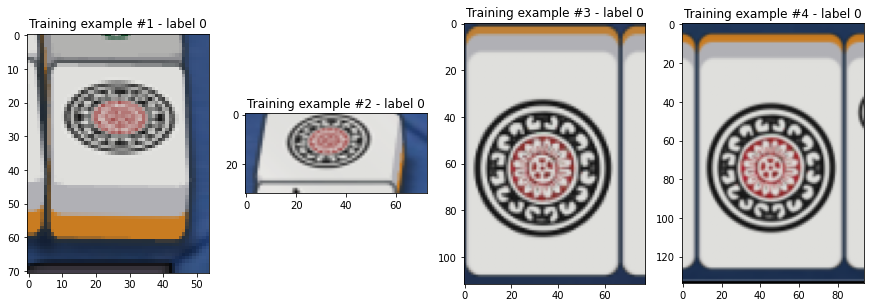

In [6]:
num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
for i in range(num_images):
    axes[i].imshow(dataset_raw[i][0].permute(1, 2, 0))
    axes[i].set_title(f"Training example #{i + 1} - label {dataset_raw[i][1]}")

## Data Preprocessing & Data augmentation

Firstly, we have to split the dataset first, for it'll cause possible data leak if we do shuffle and split after data augmentation because the new images will be all mixed.

In [7]:
# Only run once, only when you want to reproduce should set this to True
enable_split = False

# split before data enhancement to avoid data leak
if enable_split:
    for filename in os.listdir(directory_train):
            f = os.path.join(directory_train, filename)
            f_out = os.path.join(directory_test, filename)
            if not os.path.exists(f_out):
                os.makedirs(f_out)
            if os.path.isdir(f):
                samples = random.sample(os.listdir(f), k)
                for p in samples:
                    from_name = os.path.join(f, p)
                    to_name = os.path.join(f_out, p)
                    shutil.move(from_name, to_name)

Then we are able to do some data preprocessing. We resize the pictures to square with fixed size(64*64) and the parameter is specified by user. We need to convert them to the same size so we could be able to use them as the input of our data models.

Although we don't have a large number of data samples like handreds of thousands but we will do some data augmentation to enhance our dataset, which includes adding randoms noises, rotations and occlusions to improve our model's generalization.

In [8]:
# Debug switch
is_debug = False
# we only do preprocessing and augmentation for 1 time because it takes lot of time.
# If want to reproduce, set `enable_preprocessing = True`.
# If you only want to see what it generates, set `enable_preprocessing = True` and `is_debug = True`
# Then samples are generated into "./dataset_preprocessed"
enable_preprocessing = False
# output image size
fix_size = 64

# save image with noise augmentation
def noise_save(name, content):
    io.imsave(name + '-1.png', img_as_ubyte(content))
    image_noised_gaussian = random_noise(content, mode='gaussian', mean=0, var=0.01, clip=True)
    io.imsave(name + '-2.png', img_as_ubyte(image_noised_gaussian))
    image_noised_gaussian_2 = random_noise(content, mode='gaussian', mean=0, var=0.02, clip=True)
    io.imsave(name + '-3.png', img_as_ubyte(image_noised_gaussian_2))
    image_noised_s_p = random_noise(content, mode='s&p', salt_vs_pepper=0.5, clip=True)
    io.imsave(name + '-4.png', img_as_ubyte(image_noised_s_p))
    image_noised_s_p_2 = random_noise(content, mode='s&p', salt_vs_pepper=0.2, clip=True)
    io.imsave(name + '-5.png', img_as_ubyte(image_noised_s_p_2))

def occlusion_save(name, content):
    image_occlusion = content.copy()
    size_x = random.randrange(fix_size // 3, fix_size // 2)
    size_y = random.randrange(fix_size // 3, fix_size // 2)
    rr, cc = rectangle((random.randrange(0, fix_size - size_x),
                        random.randrange(0, fix_size - size_y)), 
                       extent=(size_x, size_y))
    image_occlusion[rr, cc] = 1
    io.imsave(name + '-1.png', img_as_ubyte(image_occlusion))

# save image with rotation augmentation
def rotate_save(name, content):
    for i in range(6, 7):
        occlusion_save(name + '-' + str(i), content)
    noise_save(name + '-1', content)
    content = rotate(content, 90)
    for i in range(7, 8):
        occlusion_save(name + '-' + str(i), content)
    noise_save(name + '-2', content)
    content = rotate(content, 90)
    for i in range(8, 9):
        occlusion_save(name + '-' + str(i), content)
    noise_save(name + '-3', content)
    content = rotate(content, 90)
    for i in range(9, 10):
        occlusion_save(name + '-' + str(i), content)
    noise_save(name + '-4', content)

map_dirs = [
    [directory_train, output_directory_train],
    [directory_test, output_directory_test],
]

if enable_preprocessing:
    # iterate over files in that directory
    for dir in map_dirs:
        for filename in os.listdir(dir[0]):
            f = os.path.join(dir[0], filename)
            f_out = os.path.join(dir[1], filename)
            if not os.path.exists(f_out):
                os.makedirs(f_out)
            if os.path.isdir(f):
                for imgname in os.listdir(f):
                    if (imgname in skip_list):
                        continue
                    img = os.path.join(f, imgname)
                    img_raw = io.imread(img)
                    # Resize all data to fix size
                    image_resized = resize(img_raw, (fix_size, fix_size), anti_aliasing=True)
                    rotate_save(os.path.join(f_out, imgname[0: imgname.find('.')]), image_resized)
                    if is_debug:
                        io.imshow(image_resized)
                        break
            if is_debug:
                break

## Data Exploration (Processed)

Load our data as standard input:

In [9]:
dataset_train, dataset_test = load_data()

One of the first steps when working with a new data set is exploring. The data are jointly collected, labelled and reviewed by all three of the team members to ensure its correctness and practicality.

Our data have been preprocessed and zipped into the file 'dataset_preprocessed.zip'. In the previous data block we have unzipped the data into a temporary directory and we'll do our future research over this.

With that in mind, let's see some descriptions to see some overview of our dataset and take a look at how the samples are represented.

In [10]:
print(f"The size of the full dataset is: {len(dataset_train)}\n")

print(f"The total class of the full dataset: {dataset_train.classes}\n")  # classes names

print(f"The index of these train classes: {dataset_train.class_to_idx}\n") # index of classes
print(f"The index of these test classes: {dataset_test.class_to_idx}\n") # index of classes
assert(dataset_train.class_to_idx == dataset_test.class_to_idx)

The size of the full dataset is: 15048

The total class of the full dataset: ['1b', '1t', '1w', '2b', '2t', '2w', '3b', '3t', '3w', '4b', '4t', '4w', '5b', '5t', '5w', '6b', '6t', '6w', '7b', '7t', '7w', '8b', '8t', '8w', '9b', '9t', '9w', 'bai', 'bei', 'dong', 'fa', 'nan', 'xi', 'zhong']

The index of these train classes: {'1b': 0, '1t': 1, '1w': 2, '2b': 3, '2t': 4, '2w': 5, '3b': 6, '3t': 7, '3w': 8, '4b': 9, '4t': 10, '4w': 11, '5b': 12, '5t': 13, '5w': 14, '6b': 15, '6t': 16, '6w': 17, '7b': 18, '7t': 19, '7w': 20, '8b': 21, '8t': 22, '8w': 23, '9b': 24, '9t': 25, '9w': 26, 'bai': 27, 'bei': 28, 'dong': 29, 'fa': 30, 'nan': 31, 'xi': 32, 'zhong': 33}

The index of these test classes: {'1b': 0, '1t': 1, '1w': 2, '2b': 3, '2t': 4, '2w': 5, '3b': 6, '3t': 7, '3w': 8, '4b': 9, '4t': 10, '4w': 11, '5b': 12, '5t': 13, '5w': 14, '6b': 15, '6t': 16, '6w': 17, '7b': 18, '7t': 19, '7w': 20, '8b': 21, '8t': 22, '8w': 23, '9b': 24, '9t': 25, '9w': 26, 'bai': 27, 'bei': 28, 'dong': 29, 'fa': 3

Here I choose `index=0` to look at the very first sample. We first notice `dataset[0][1]=0`, meaning this entry is the type `0` - '1b'. We will confirm this shortly by visualizing some of these samples. We then notice each entry is an integer ranging from `0-1.0`. This representation is uncommon when working with images since they should be within the range of `0-255`. The numerical entries are interpreted as pixel intensities typically shown in gray-scale ranging between `0` (black) and `255` (white). But we use `torchvision.transforms.ToTensor` in our loading process and it will `converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]` according to the document.

In [11]:
index = 0
print(f"feature: {dataset_train[index][0].shape} - label {dataset_train[index][1]}")
print(dataset_train[index][0])
print(f"testset[{index}] range from {torch.min(dataset_train[index][0])} to {torch.max(dataset_train[index][0])}.")

feature: torch.Size([3, 64, 64]) - label 0
tensor([[[0.8745, 0.8745, 0.8471,  ..., 0.2000, 0.2000, 0.2000],
         [0.8745, 0.8745, 0.8627,  ..., 0.2039, 0.2039, 0.2039],
         [0.8745, 0.8745, 0.8706,  ..., 0.2078, 0.2078, 0.2118],
         ...,
         [0.0941, 0.0824, 0.0706,  ..., 0.2039, 0.1961, 0.1922],
         [0.0824, 0.1059, 0.1333,  ..., 0.2000, 0.1961, 0.1882],
         [0.1843, 0.2000, 0.2118,  ..., 0.1961, 0.1922, 0.1843]],

        [[0.8745, 0.8745, 0.8471,  ..., 0.3059, 0.3059, 0.3059],
         [0.8745, 0.8745, 0.8627,  ..., 0.3098, 0.3098, 0.3098],
         [0.8745, 0.8745, 0.8706,  ..., 0.3098, 0.3137, 0.3176],
         ...,
         [0.1529, 0.1255, 0.1059,  ..., 0.3216, 0.3176, 0.3098],
         [0.0863, 0.1059, 0.1294,  ..., 0.3216, 0.3137, 0.3059],
         [0.1765, 0.1882, 0.2039,  ..., 0.3137, 0.3059, 0.2980]],

        [[0.8627, 0.8627, 0.8392,  ..., 0.4980, 0.4980, 0.4980],
         [0.8627, 0.8627, 0.8510,  ..., 0.5020, 0.5020, 0.5020],
         [0.862

Let's import `matplotlib.pyplot` to see some sample images.

In [12]:
import matplotlib.pyplot as plt 

Let's start with the first 4 examples.

The first 4 examples all belong to label 0 and some images are generated from data augmentation to obtain better generalization of our model. We can see some examples with random noise in them.

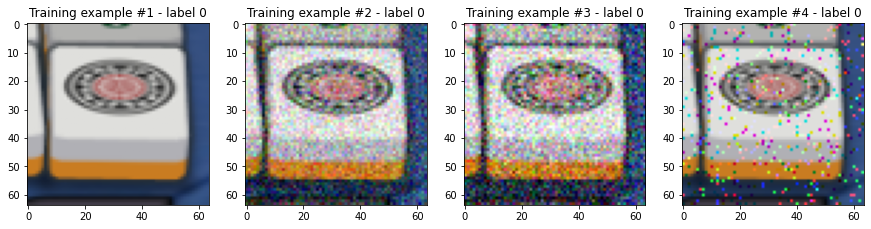

In [13]:
num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
for i in range(num_images):
    axes[i].imshow(dataset_train[i][0].permute(1, 2, 0))
    axes[i].set_title(f"Training example #{i + 1} - label {dataset_train[i][1]}")

Let's continue with the some examples from type '1b'.

We can see from the following examples that some images are processed with rotation and random occlusions. That's one reason why we need deep learning model here.

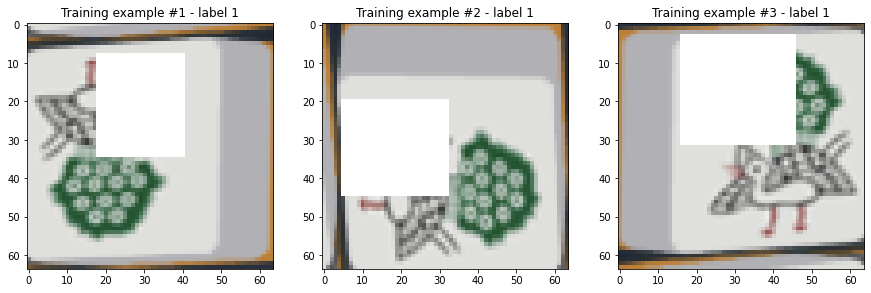

In [14]:
images = [573, 574, 575]
fig, axes = plt.subplots(1, len(images), figsize=(15, 10))

for i in range(len(images)):
    index = images[i]
    axes[i].imshow(dataset_train[index][0].permute(1, 2, 0))
    axes[i].set_title(f"Training example #{i + 1} - label {dataset_train[index][1]}")

Let's continue to explore some random images.

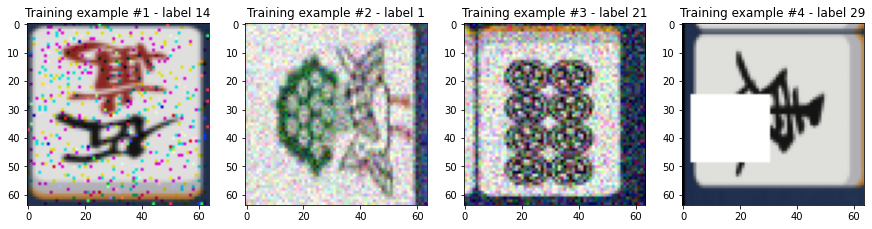

In [15]:
from random import randint
num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
for i in range(num_images):
    value = randint(0, len(dataset_train))
    axes[i].imshow(dataset_train[value][0].permute(1, 2, 0))
    axes[i].set_title(f"Training example #{i + 1} - label {dataset_train[value][1]}")

## Data loading

We already split our data to training set and validation set. Simply load them from our preprocessed data.

In [3]:
# validation_set_ratio = 0.2
# n = len(dataset)  # total number of examples
# n_test = int(validation_set_ratio * n)
# subsets = torch.utils.data.random_split(dataset, [n - n_test, n_test], generator=torch.Generator().manual_seed(42))
# train_set = subsets[0]
# test_set = subsets[1]
# print(train_set.__len__(), test_set.__len__()) # [train_set, validation_set]
# print(type(train_set.dataset))

dataset_train, dataset_test = load_data()
train_data_loader, test_data_loader = data_loader(dataset_train, dataset_test)

In [4]:
# Sample for using the above data loaders
for i, data in enumerate(train_data_loader, 0):
    # iteration index, torch.Size([32, 64, 64, 3]) torch.Size([32])
    print(i, data[0].permute(0, 2, 3, 1).shape, data[1].shape)
    break

0 torch.Size([32, 64, 64, 3]) torch.Size([32])


## MLP Baseline

Building the MLP Baseline model

In [5]:
import os
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

# Define Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 768)
        self.fc2 = nn.Linear(768, 84)
        self.fc3 = nn.Linear(84, 34)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

torch.manual_seed(34)
mlp = MLP()
  
  # Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

a, b = 0, 0
# Run 20 epoches
for epoch in range(0, 20): 
    print(f'Starting epoch {epoch+1}')
    current_loss = 0.0

    for i, data in enumerate(train_data_loader, 0):
        inputs, targets = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = mlp(inputs)
        _,train_label = torch.max(outputs.data, 1)
        a += targets.size(0)
        b += (train_label == targets).sum().item()
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        if i % 470 == 469:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 470))
            current_loss = 0.0

print(f'MLP training process done.')

# Run test data set
all_labels = 0
good_labels = 0
for data in test_data_loader:
    inputs, targets = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = mlp(inputs)
    a, pred_labels = torch.max(outputs.data, 1)
    all_labels += targets.size(0)
    good_labels += (pred_labels == targets).sum().item()

accuracy = (100 * good_labels) // all_labels
print(f'MLP test accuracy: {accuracy} %')

Starting epoch 1
Loss after mini-batch   470: 3.237
Starting epoch 2
Loss after mini-batch   470: 2.456
Starting epoch 3
Loss after mini-batch   470: 2.000
Starting epoch 4
Loss after mini-batch   470: 1.691
Starting epoch 5
Loss after mini-batch   470: 1.438
Starting epoch 6
Loss after mini-batch   470: 1.233
Starting epoch 7
Loss after mini-batch   470: 1.073
Starting epoch 8
Loss after mini-batch   470: 0.941
Starting epoch 9
Loss after mini-batch   470: 0.828
Starting epoch 10
Loss after mini-batch   470: 0.738
Starting epoch 11
Loss after mini-batch   470: 0.651
Starting epoch 12
Loss after mini-batch   470: 0.583
Starting epoch 13
Loss after mini-batch   470: 0.521
Starting epoch 14
Loss after mini-batch   470: 0.458
Starting epoch 15
Loss after mini-batch   470: 0.413
Starting epoch 16
Loss after mini-batch   470: 0.363
Starting epoch 17
Loss after mini-batch   470: 0.321
Starting epoch 18
Loss after mini-batch   470: 0.282
Starting epoch 19
Loss after mini-batch   470: 0.251
St

## Resnet

Building a ResNet34 model

In [26]:
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, down_sample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=(stride, stride), padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=(1,1), padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.down_sample = down_sample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.down_sample:
            residual = self.down_sample(x)
        out += residual
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7,7), stride=(2,2), padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.max_pool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=1)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=1)
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2048, num_classes)

    def _make_layer(self, block, planes, blocks, stride = 1):
        down_sample = None
        if stride != 1 or self.in_planes != planes:
            down_sample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, kernel_size=(1,1), stride=(stride,stride)),
                nn.BatchNorm2d(planes)
            )
        layers = []
        layers.append(block(self.in_planes, planes, stride, down_sample))
        self.in_planes = planes
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

lr = 0.001
gamma = 0.9
num_epoch = 2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet(ResidualBlock, [3,4,6,3], num_classes=34).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=gamma, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


Now train the model.

In [27]:
import datetime
import gc

now = datetime.datetime.now()
weight_save_path = 'weight-resnet34-' + now.strftime("%Y%m%d%H%M%S")
# train the model
for epoch in range(num_epoch):
    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 50 == 0:
            print('epoch {}|{}  {:5d} batches loss: {:.7f}'.format(epoch, num_epoch, i + 1, running_loss / 50))
            running_loss = 0.0
            torch.save(model.state_dict(), weight_save_path)
        gc.collect()
    scheduler.step()

print('Finished Training, the model weights are saved in {}'.format(weight_save_path))

epoch 0|20     50 batches loss: 3.7346846
epoch 0|20    100 batches loss: 2.7569997
epoch 0|20    150 batches loss: 2.4326094
epoch 0|20    200 batches loss: 2.0642350
epoch 0|20    250 batches loss: 1.8857925
epoch 0|20    300 batches loss: 1.6755240
epoch 0|20    350 batches loss: 1.5748443
epoch 0|20    400 batches loss: 1.5136755
epoch 0|20    450 batches loss: 1.3899480
Adjusting learning rate of group 0 to 9.0000e-04.
epoch 1|20     50 batches loss: 1.2876973
epoch 1|20    100 batches loss: 1.1320514
epoch 1|20    150 batches loss: 1.1045639
epoch 1|20    200 batches loss: 1.0033429
epoch 1|20    250 batches loss: 0.9158088
epoch 1|20    300 batches loss: 0.8822004
epoch 1|20    350 batches loss: 0.7263714
epoch 1|20    400 batches loss: 0.7388022
epoch 1|20    450 batches loss: 0.6721338
Adjusting learning rate of group 0 to 8.1000e-04.
epoch 2|20     50 batches loss: 0.5683396
epoch 2|20    100 batches loss: 0.5497862
epoch 2|20    150 batches loss: 0.5428102
epoch 2|20    200 

epoch 19|20     50 batches loss: 0.0034748
epoch 19|20    100 batches loss: 0.0039055
epoch 19|20    150 batches loss: 0.0025558
epoch 19|20    200 batches loss: 0.0019875
epoch 19|20    250 batches loss: 0.0020460
epoch 19|20    300 batches loss: 0.0036029
epoch 19|20    350 batches loss: 0.0024539
epoch 19|20    400 batches loss: 0.0017505
epoch 19|20    450 batches loss: 0.0024429
Adjusting learning rate of group 0 to 1.2158e-04.
Finished Training, the model weights are saved in weight-resnet34-20221026225151


Now evaluate the model using testing set

In [ ]:
model.load_state_dict(torch.load(weight_save_path))
correct, total = 0, 0
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 96 %


## Garbage Collection

Let's do some clean up before finish.

In [ ]:
shutil.rmtree(temp_path, ignore_errors=True)

## Model Comparison

## Analysis and Conclusion

## Future Thoughts

## Appenix